
# Sparse Attention: Efficient Attention with Sparsity

## Introduction to Sparse Attention

Sparse Attention is an efficient variant of the attention mechanism that addresses the quadratic complexity problem of standard attention by focusing on a subset of input elements. Various sparse attention patterns have been proposed, such as local attention, strided attention, and random attention.
  
The key idea is to limit the number of elements each query attends to, reducing the complexity from O(n^2) to O(n * k), where n is the sequence length and k is the number of elements each query attends to.


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

torch.manual_seed(42)

# Our example phrase
phrase = "The quick brown fox jumps over the lazy dog"
words = phrase.split()
sequence_length = len(words)

# Hyperparameters
batch_size = 1
embedding_dim = 8
num_heads = 2
head_dim = embedding_dim // num_heads
sparsity_factor = 2  # Each query attends to sequence_length / sparsity_factor elements

# Create a simple embedding for our words
word_to_idx = {word: idx for idx, word in enumerate(words)}
embeddings = torch.randn(len(words), embedding_dim)

# Input
X = embeddings.unsqueeze(0)  # Add batch dimension
print("Input shape:", X.shape)

# Weight matrices
W_q = torch.randn(embedding_dim, embedding_dim)
W_k = torch.randn(embedding_dim, embedding_dim)
W_v = torch.randn(embedding_dim, embedding_dim)
W_o = torch.randn(embedding_dim, embedding_dim)

Input shape: torch.Size([1, 9, 8])


## Sparse Attention Mask
  
The core of sparse attention's efficiency comes from the attention mask. This mask determines which elements each query can attend to. We'll implement a simple strided attention pattern, where each query attends to every `sparsity_factor`-th element.


In [2]:
def create_sparse_mask(seq_length, sparsity_factor):
    mask = torch.zeros(seq_length, seq_length, dtype=torch.bool)
    for i in range(seq_length):
        for j in range(0, seq_length, sparsity_factor):
            mask[i, j] = True
    return mask

sparse_mask = create_sparse_mask(sequence_length, sparsity_factor)

print("Sparse mask shape:", sparse_mask.shape)

Sparse mask shape: torch.Size([9, 9])


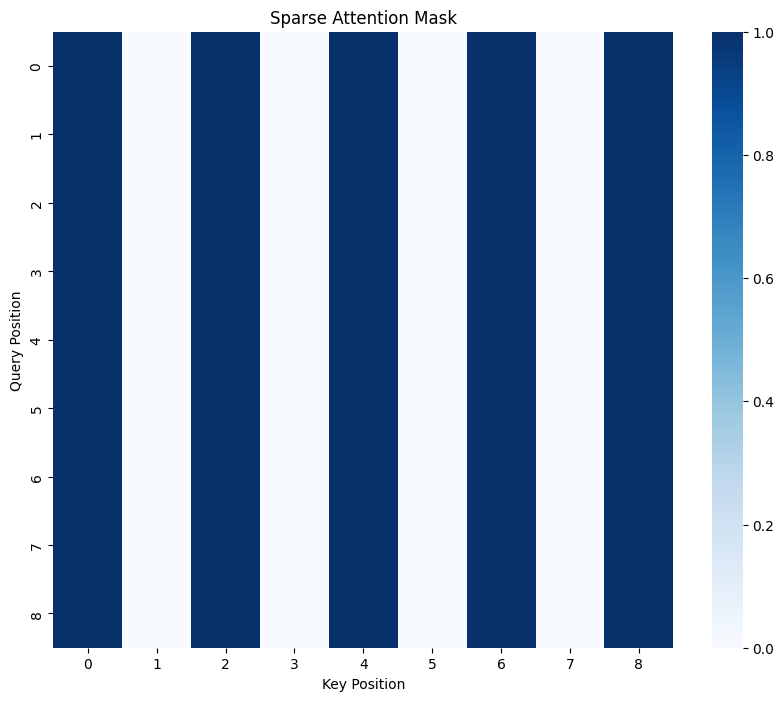

In [3]:
# Visualization of sparse mask
plt.figure(figsize=(10, 8))
sns.heatmap(sparse_mask.float(), cmap="Blues")
plt.title("Sparse Attention Mask")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.show()

## Compute Q, K, V and Reshape for Multi-head Attention
  
Similar to standard attention, we compute Q, K, and V matrices and reshape them for multi-head attention. This part is identical to the standard attention mechanism.


In [4]:
# Calculate Q, K, V matrices
Q = torch.matmul(X, W_q)
K = torch.matmul(X, W_k)
V = torch.matmul(X, W_v)

# Reshape Q, K, V for multi-head attention
Q = Q.view(batch_size, sequence_length, num_heads, head_dim).transpose(1, 2)
K = K.view(batch_size, sequence_length, num_heads, head_dim).transpose(1, 2)
V = V.view(batch_size, sequence_length, num_heads, head_dim).transpose(1, 2)

print("Q shape after reshape:", Q.shape)
print("K shape after reshape:", K.shape)
print("V shape after reshape:", V.shape)

Q shape after reshape: torch.Size([1, 2, 9, 4])
K shape after reshape: torch.Size([1, 2, 9, 4])
V shape after reshape: torch.Size([1, 2, 9, 4])


## Compute Sparse Attention Scores
 
We compute attention scores similarly to standard attention, but we apply the sparse mask to limit which elements each query attends to.


In [5]:
# Calculate attention scores
scores = torch.matmul(Q, K.transpose(-2, -1)) / (head_dim ** 0.5)

# Apply sparse mask
scores = scores.masked_fill(~sparse_mask.unsqueeze(0).unsqueeze(0), float('-inf'))

print("Attention scores shape:", scores.shape)

Attention scores shape: torch.Size([1, 2, 9, 9])


In [6]:
# Apply softmax to get attention weights
attn_weights = F.softmax(scores, dim=-1)

print("Attention weights shape:", attn_weights.shape)

Attention weights shape: torch.Size([1, 2, 9, 9])


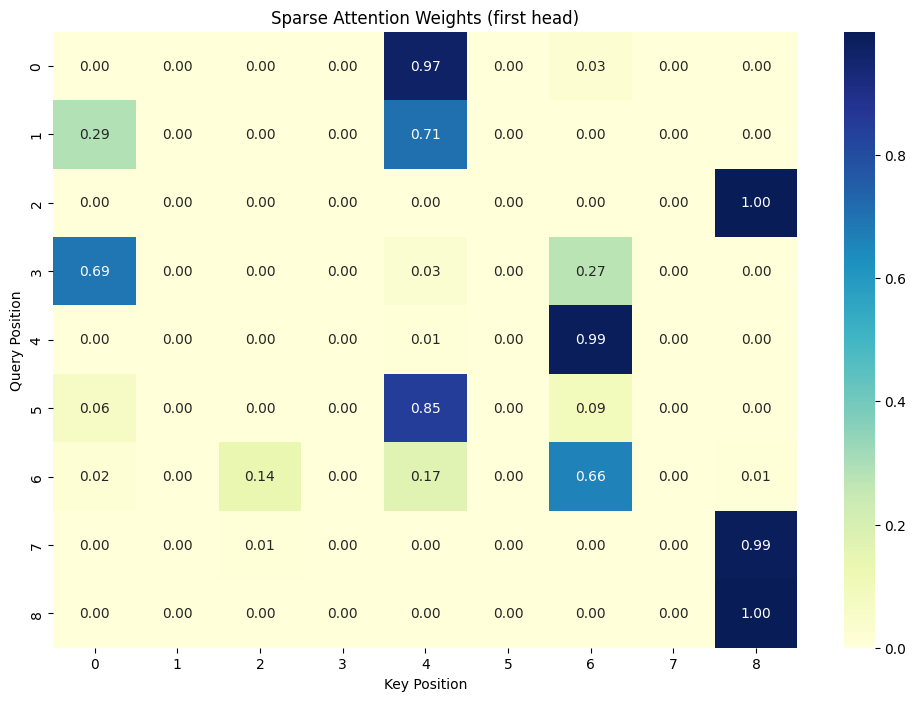

In [7]:
plt.figure(figsize=(12, 8))
sns.heatmap(attn_weights[0, 0].detach().numpy(), cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Sparse Attention Weights (first head)")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.show()


## Compute Attention Output

We apply the attention weights to the Values. This step is similar to standard attention, but uses the sparse attention weights.


In [9]:
# Apply attention weights to values
attn_output = torch.matmul(attn_weights, V)

print("Attention output shape:", attn_output.shape)

Attention output shape: torch.Size([1, 2, 9, 4])


## Reshape and Project Output
  
Finally, we reshape the attention output and apply the output projection. This step is identical to standard attention.


In [10]:
# Reshape and project output
attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, sequence_length, embedding_dim)
output = torch.matmul(attn_output, W_o)

print("Final output shape:", output.shape)

Final output shape: torch.Size([1, 9, 8])


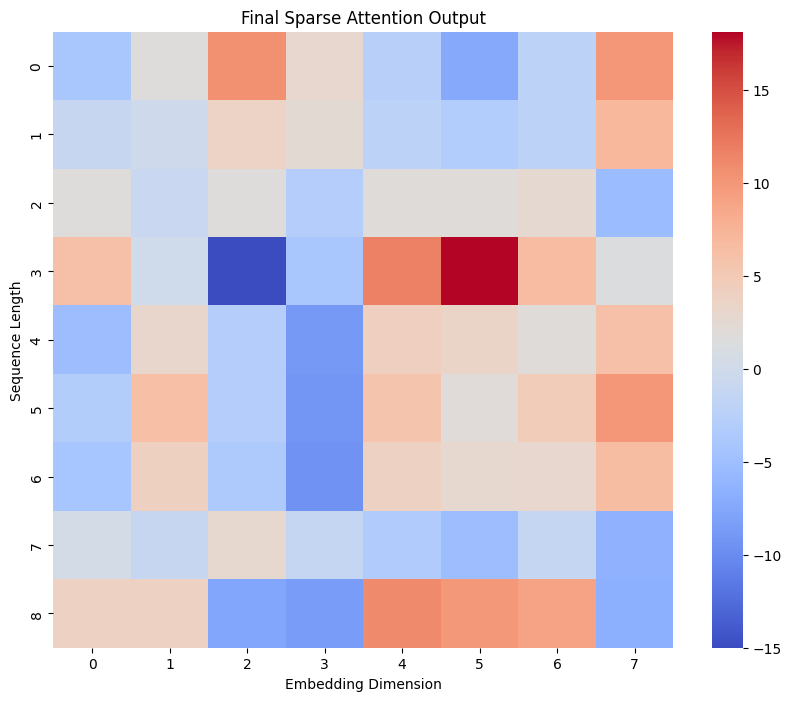

In [11]:
# Visualize final output
plt.figure(figsize=(10, 8))
sns.heatmap(output[0], cmap="coolwarm")
plt.title("Final Sparse Attention Output")
plt.xlabel("Embedding Dimension")
plt.ylabel("Sequence Length")
plt.show()


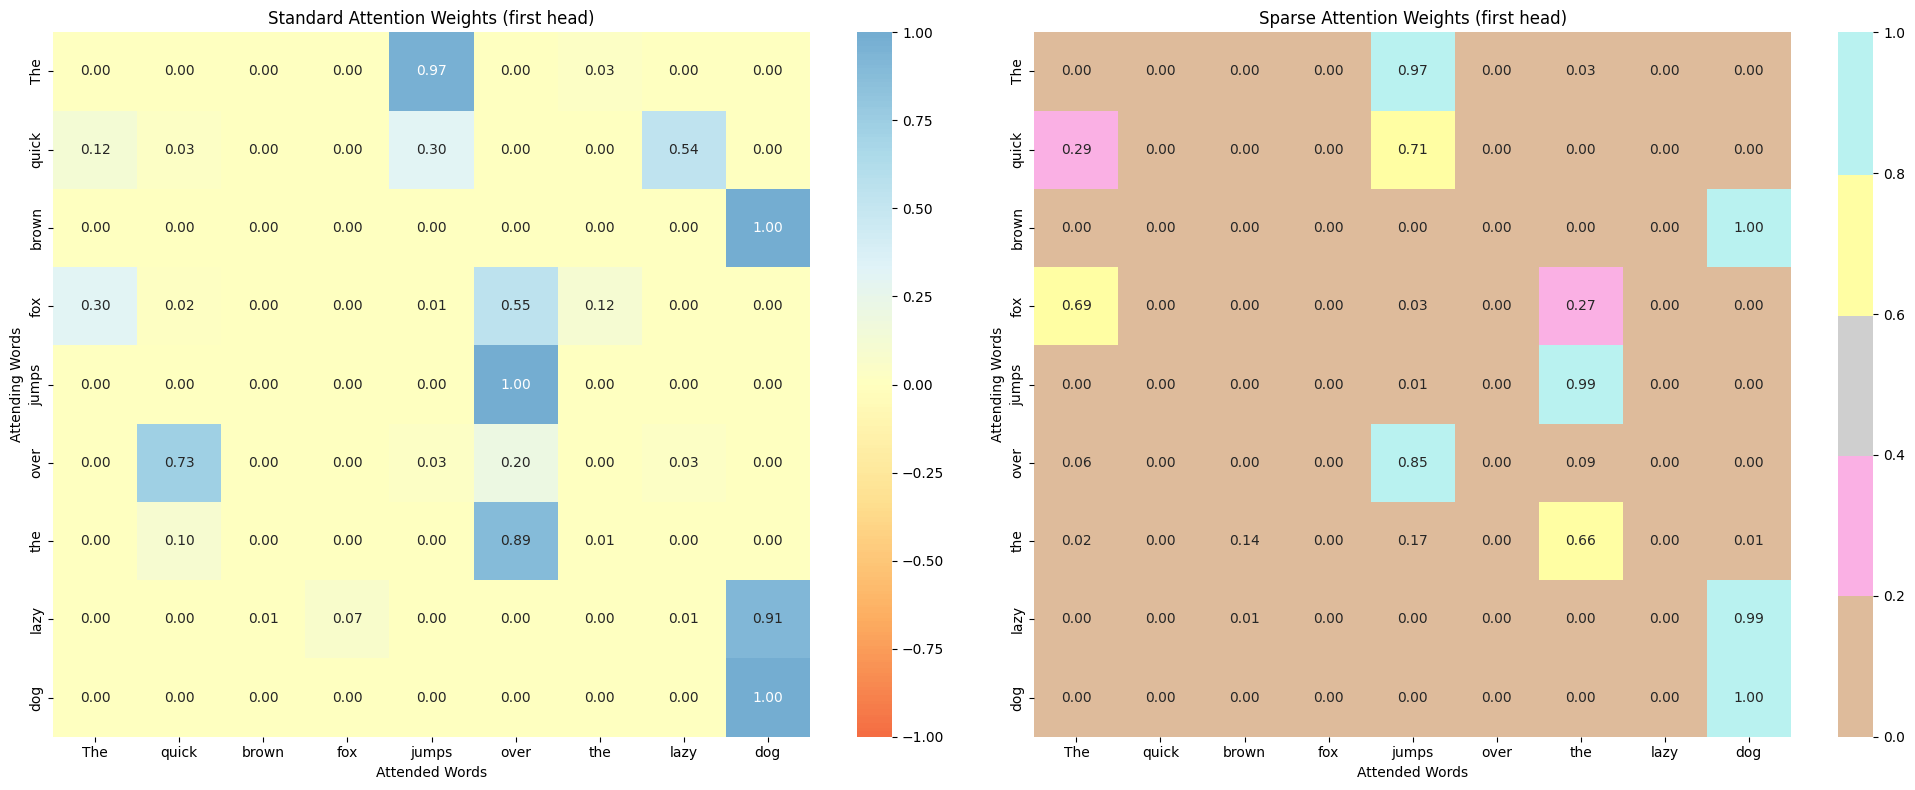

In [12]:
def standard_attention(Q, K, V):
    scores = torch.matmul(Q, K.transpose(-2, -1)) / (K.size(-1) ** 0.5)
    attn_weights = F.softmax(scores, dim=-1)
    return attn_weights, torch.matmul(attn_weights, V)

# Compute standard attention weights
std_attn_weights, _ = standard_attention(Q, K, V)

# Create pastel RdYlBu colormap
rdylbu = plt.cm.RdYlBu
pastel_rdylbu = LinearSegmentedColormap.from_list("pastel_rdylbu", rdylbu(np.linspace(0.2, 0.8, 256)))

# Create pastel colormap for Sparse Attention
pastel = sns.color_palette("pastel", as_cmap=True)

# Visualize standard vs Sparse attention weights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(std_attn_weights[0, 0].detach().numpy(), ax=ax1, cmap=pastel_rdylbu,
            annot=True, fmt=".2f", center=0, vmin=-1, vmax=1,
            xticklabels=words, yticklabels=words)
ax1.set_title("Standard Attention Weights (first head)")
ax1.set_xlabel("Attended Words")
ax1.set_ylabel("Attending Words")

sns.heatmap(attn_weights[0, 0].detach().numpy(), ax=ax2, cmap=pastel,
            annot=True, fmt=".2f", center=0, vmin=0, vmax=1,
            xticklabels=words, yticklabels=words)
ax2.set_title("Sparse Attention Weights (first head)")
ax2.set_xlabel("Attended Words")
ax2.set_ylabel("Attending Words")

plt.tight_layout()
plt.show()

## Conclusion
 
Sparse Attention achieves linear complexity by limiting the number of elements each query attends to. 
This allows it to handle longer sequences more efficiently than standard attention, while still 
maintaining most of the expressiveness of the attention mechanism.

Key observations from our visualizations:
 
1. The sparse mask determines which elements each query can attend to, creating a specific sparsity pattern.
2. The attention weights in Sparse Attention have the same shape as standard attention, but many elements are zero.
3. Despite the sparsity, Sparse Attention still captures meaningful attention patterns.

Advantages of Sparse Attention:
1. Linear time and space complexity, allowing for processing of longer sequences.
2. Flexibility in designing different sparsity patterns for different tasks.
3. Can be combined with other efficient attention mechanisms for further improvements.
 
Limitations of Sparse Attention:
1. The choice of sparsity pattern can significantly affect performance and may need to be tuned for each task.
2. Some global dependencies might be missed due to the sparsity, especially for very long sequences.
3. Implementation can be more complex than standard attention, especially for efficient sparse matrix operations.

Sparse Attention represents an important approach in developing more efficient attention mechanisms, 
especially for tasks involving long sequences or where specific attention patterns are known to be 
beneficial. Its ideas continue to influence research in this area and have been applied in various 
domains beyond natural language processing.